# 기본 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.set(font="Malgun Gothic")
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# 데이터 분할 및 평가 지표

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

# XGBoost 라이브러리

In [3]:
import xgboost as xgb
from xgboost import plot_importance 
from xgboost import XGBRegressor

# RandomForest 라이브러리

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# LightGBM 라이브러리

In [5]:
from lightgbm import LGBMRegressor

# 파라미터 튜닝 함수

In [153]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import optuna

# 빈도테이블 생성

In [6]:
def count(x):
    data1=pd.DataFrame(x.value_counts()).reset_index()
    data1.columns=['category','빈도수']
    return data1

# Barplot 생성

In [7]:
def bargraph(x,y,x_label,y_label,figsize1,figsize2,data):
    plt.figure(figsize=(figsize1, figsize2))
    if data[x].dtypes=='int64':
        data[x]=data[x].astype('str')
    data=data.sort_values(by=y,ascending=False).reset_index()
    
    for index, row in data.iterrows():
        g=sns.barplot(x,y,data=data)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        g.text(index,row[y],row[y],color='black',ha='center')

# 성능 지표 추출

In [8]:
# 성능지표 추출
def Evaluation_metric(actual,pred):
    print(f'MAE: {round(mean_absolute_error(actual,pred),2)}')
    print(f'MSE: {round(mean_squared_error(actual,pred),2)}')
    print(f'RMSE: {round(sqrt(mean_squared_error(actual,pred)),2)}')
    print(f'RMSPE: {round(sqrt(mean_squared_error(actual,pred))/np.mean(actual)*100,2)}%')

# 시드 고정

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# 데이터 불러오기

In [10]:
# Train, Valid, Test Split용 데이터
data=pd.read_csv(os.listdir()[8],encoding='EUC-KR')
# 지표 확인용 데이터
data_real=pd.read_csv(os.listdir()[8],encoding='EUC-KR')
# 배정신청인원 0명 제거
data=data.query('합계!=0')
#필요 컬럼 추출
#selected_columns_1=['구분','합계', '작물 종류','농지면적(실제경작)','전년대비농경체증감률','고령농경체비율','전년도이탈인원','전년도활용여부']
selected_columns=['비고', '지자체명_시도', '지자체명_시군구', '구분', '농업경영체','합계', '작물 종류','농지면적(실제경작)','전년대비농경체증감률','고령농경체비율','전년도이탈인원','전년도활용여부'] #원본 데이터 컬럼
data=data[selected_columns]
data_real=data_real[selected_columns]
# 농지면적(실제경작) 컬럼명 변경
data.rename(columns={'농지면적(실제경작)':'농지면적','작물 종류':'작물종류'},inplace=True)

# 이상치 제거: 농지 면적, 합계

In [11]:
data=data.query('0.04<농지면적<2.5')
data=data.query('합계<11')

# 데이터 분할 Train, Valid, Test

In [12]:
# 작물 종류 기준 층화 추출 Train Test 비율 8:2
X=data.drop(columns=['비고','농업경영체','합계']) #독립변수 Set
Y=data['합계'] #Target 변수 set

# Train, Test 분할
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,stratify=X['작물종류'],random_state=42)

# 2차 Train, Validation 분할
X_train, X_valid, Y_train, Y_valid=train_test_split(X_train,Y_train,test_size=0.2,stratify=X_train['작물종류'],random_state=42)

# 연속형 변수 정규화 & 범주형 변수 라벨 인코딩 진행

In [13]:
# 연속형 변수 정규화
min_max_scaler=MinMaxScaler()
for i in X_train.columns:
    if (X_train[i].dtypes!='object'):
        X_train[i]=min_max_scaler.fit_transform(X_train[[i]])
        X_valid[i]=min_max_scaler.transform(X_valid[[i]])
        X_test[i]=min_max_scaler.transform(X_test[[i]])
    else:
        pass

In [14]:
# 범주형 변수 라벨 인코딩
label_encoder=LabelEncoder()
for i in X_train.columns:
    if X_train[i].dtypes=='object':
        X_train[i]=label_encoder.fit_transform(X_train[i])
        X_valid[i]=label_encoder.transform(X_valid[i])
        X_test[i]=label_encoder.transform(X_test[i])
    else:
        pass

# XGBoost parameter Tuning

- 주요 파라미터 설명

- gamma(값이 클수록 과적합을 방지해줌)=> [0,∞], 기본값=0=> 손실감소량에 대한 임계치임
ex) gamma가 2일때 loss가 2이하면 더 이상 트리 분할 X

- max_depth= Tree maximum depth 값
ex) 최대 가지 개수

- subsample= 데이터 샘플링 비율
ex) 0.8로 설정하면 각 트리가 학습할 때 전체 데이터의 80% 사용 => 과적합 방지
-------------------------------------------------------------------------------------------------------------


- 초기 파라미터
- dart부스터 학습률 0.05, 한트리의 최대 깊이 8, 반복 학습 횟수 200회로 진행
- XGBRegressor(booster='dart',learning_rate=0.05, max_depth=8, n_estimator=200)

-------------------------------------------------------------------------------------------------------------

- 파라미터 튜닝

- 학습률 0.05~0.01

- gamma 0~2

- max_depth 6~9

- subsample 0.5~1

- 반복수 100~300

# 초기 기본 모델

농업경영체별 평가지표 결과
MAE: 1.26
MSE: 3.04
RMSE: 1.74
RMSPE: 51.63%
----------------------------------------------------------------------------------------------------
배정신청인원 10명 이상 시군구 단위 평가지표
MAE: 8.11
MSE: 134.37
RMSE: 11.59
RMSPE: 14.15%
----------------------------------------------------------------------------------------------------
변수중요도 Graph


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

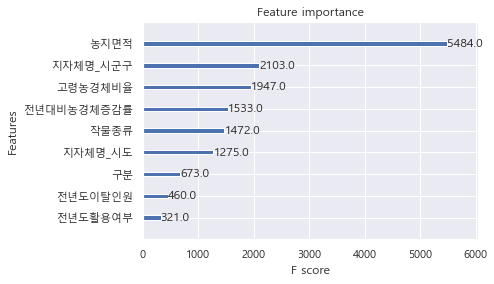

In [164]:
# XGB regressor 모델 구축
# dart부스터 학습률 0.05, 한트리의 최대 깊이 8, 반복 학습 횟수 200회로 진행=> 파라미터 튜닝 X
model_reg=XGBRegressor(booster='dart',learning_rate=0.05, max_depth=8, n_estimator=200)
# 모델 적용
model_reg.fit(X_train,Y_train)
#예측값 
pred=model_reg.predict(X_test)
# 인원 수 예측이기에 예측된 결과에 반올림 적용
pred=pd.DataFrame(pred,columns=['예측값'])
#반올림
pred['예측값']=round(pred['예측값'],0)
#평가지표
print('농업경영체별 평가지표 결과')
Evaluation_metric(Y_test,pred=pred)
print('-'*100)

test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)
#예측값
data_test['predict']=pred
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()
result_1=result.query('합계>10')
print('배정신청인원 10명 이상 시군구 단위 평가지표')
Evaluation_metric(result_1['합계'],pred=result_1['predict'])
print('-'*100)
print('변수중요도 Graph')
# 변수 중요도 확인
plot_importance(model_reg)

# Bayesian Optimization 튜닝

In [163]:
# 목적 함수 정의
results = {
    'max_depth': [],
    'gamma': [],
    'subsample': [],
    'n_estimator': [],
    'learning_rate': [],
    'target': []  # 최적화 결과인 target 값 저장
}

def xgb_cv(max_depth, gamma, subsample, n_estimator, learning_rate):
    params = {
        'eval_metric': 'rmse',
        'max_depth': int(max_depth),
        'gamma': gamma,
        'subsample': subsample,
        'n_estimator': int(n_estimator),
        'learning_rate': learning_rate,
        'booster': 'dart'
    }
    
    # XGBoost Regressor 모델 초기화
    model_reg = xgb.XGBRegressor(**params)
    
    #model Train 학습
    model_reg.fit(X_train,Y_train)
    #model validation
    scores = -cross_val_score(model_reg, X_valid, Y_valid, cv=5, scoring='neg_mean_squared_error').mean()
    results['max_depth'].append(max_depth)
    results['gamma'].append(gamma)
    results['subsample'].append(subsample)
    results['n_estimator'].append(n_estimator)
    results['learning_rate'].append(learning_rate)
    results['target'].append(scores)
    return scores

# Bayesian Optimization 수행
xgbBO = BayesianOptimization(
    xgb_cv,
    {'max_depth': (8, 10),
     'gamma': (1, 2),
     'subsample': (0.85, 1.0),
     'n_estimator': (200, 250),
     'learning_rate': (0.04,0.05)}
)

# 최적화
xgbBO.maximize(init_points=10, n_iter=15)

idx_of_min=results['target'].index(min(results['target']))
min_pam={'booster':'dart'}
for key,value in results.items():
    if key=='target':
        pass
    else:
        if (key=='max_depth') or (key=='n_estimator'):
            min_pam[key]=int(round(value[idx_of_min],0))
        else:
            min_pam[key]=value[idx_of_min]
            
print(f'최종 파라미터는 {min_pam}입니다')

model_reg = xgb.XGBRegressor(**min_pam)
model_reg.fit(X_train,Y_train)

#예측값 
pred=model_reg.predict(X_test)
# 인원 수 예측이기에 예측된 결과에 반올림 적용
pred=pd.DataFrame(pred,columns=['예측값'])
#반올림
pred['예측값']=round(pred['예측값'],0)
#평가지표
print('농업경영체별 평가지표 결과')
Evaluation_metric(Y_test,pred=pred)
print('-'*100)

test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)
#예측값
data_test['predict']=pred
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()
result_1=result.query('합계>10')
print('배정신청인원 10명 이상 시군구 단위 평가지표')
Evaluation_metric(result_1['합계'],pred=result_1['predict'])

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 3.445     | 1.213     | 0.04838   | 9.834     | 221.3     | 0.9193    |
| 2         | 3.398     | 1.958     | 0.04594   | 9.233     | 201.6     | 0.8514    |
| 3         | 3.382     | 1.937     | 0.04193   | 8.489     | 236.6     | 0.925     |
| 4         | 3.444     | 1.696     | 0.048     | 9.318     | 228.7     | 0.9747    |
| 5         | 3.374     | 1.294     | 0.04065   | 8.644     | 219.2     | 0.8901    |
| 6         | 3.387     | 1.807     | 0.04894   | 8.723     | 230.9     | 0.9015    |
| 7         | 3.398     | 1.938     | 0.04729   | 9.533     | 245.0     | 0.8712    |
| 8         | 3.412     | 2.0       | 0.04954   | 9.645     | 202.0     | 0.9157    |
| 9         | 3.391     | 1.434     | 0.0415    | 8.925     | 224.1     | 0.9036    |
| 10        | 3.413     | 1.929     | 0.04767   | 9.55

# OPTUNA 라이브러리 활용 파라미터 튜닝

파라미터 튜닝 코드

- optuna.trial.Trial.suggest_categorical() : 리스트 범위 내에서 값을 선택한다.
- optuna.trial.Trial.suggest_int() : 범위 내에서 정수형 값을 선택한다.
- optuna.trial.Trial.suggest_float() : 범위 내에서 소수형 값을 선택한다.
- optuna.trial.Trial.suggest_uniform() : 범위 내에서 균일분포 값을 선택한다.
- optuna.trial.Trial.suggest_discrete_uniform() : 범위 내에서 이산 균일분포 값을 선택한다.
- optuna.trial.Trial.suggest_loguniform() : 범위 내에서 로그 함수 값을 선택한다.

In [168]:
def objective(trial):
    params={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth',8,10), #8~10 정수중 택 1
        'gamma': trial.suggest_loguniform('gamma',1,2),
        'subsample': trial.suggest_categorical('subsample',[0.8,0.85,0.90,0.95,1]),
        'n_estimator': trial.suggest_int('n_estimator',200,400),
        'learning_rate': trial.suggest_float('learning_rate',0.03,0.05),
        'booster': 'dart'   
    }
    # 학습 모델 생성
    model_reg=xgb.XGBRegressor(**params)
    
    #트레인 셋 학습
    model_reg.fit(X_train,Y_train)
    
    #검증 데이터 셋으로 모델 검증
    score = mean_absolute_error(model_reg.predict(X_valid), Y_valid)
    return score

study=optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

[I 2023-11-27 15:13:25,224] A new study created in memory with name: no-name-6a769504-4d83-4ce2-8d01-10f98cd87c40
[I 2023-11-27 15:13:27,040] Trial 0 finished with value: 1.3074086704312928 and parameters: {'max_depth': 10, 'gamma': 1.0518009702177216, 'subsample': 0.85, 'n_estimator': 395, 'learning_rate': 0.037149864247310635}. Best is trial 0 with value: 1.3074086704312928.
[I 2023-11-27 15:13:28,676] Trial 1 finished with value: 1.3017141643890553 and parameters: {'max_depth': 8, 'gamma': 1.7427297878814498, 'subsample': 0.8, 'n_estimator': 287, 'learning_rate': 0.03868242423775573}. Best is trial 1 with value: 1.3017141643890553.
[I 2023-11-27 15:13:30,475] Trial 2 finished with value: 1.3172703817923006 and parameters: {'max_depth': 10, 'gamma': 1.8278468997404353, 'subsample': 1, 'n_estimator': 345, 'learning_rate': 0.030085411375682717}. Best is trial 1 with value: 1.3017141643890553.
[I 2023-11-27 15:13:32,325] Trial 3 finished with value: 1.3039848058727013 and parameters: {'

In [169]:
# 최적화된 파라미터 값 확인
best_params = study.best_params
print(best_params)

{'max_depth': 9, 'gamma': 1.028982074480852, 'subsample': 0.8, 'n_estimator': 356, 'learning_rate': 0.047317109170411646}


In [170]:
model_reg = xgb.XGBRegressor(**best_params)
model_reg.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.028982074480852, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.047317109170411646,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=356, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [171]:
#예측값 
pred=model_reg.predict(X_test)
# 인원 수 예측이기에 예측된 결과에 반올림 적용
pred=pd.DataFrame(pred,columns=['예측값'])
#반올림
pred['예측값']=round(pred['예측값'],0)
#평가지표
print('농업경영체별 평가지표 결과')
Evaluation_metric(Y_test,pred=pred)
print('-'*100)

test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)
#예측값
data_test['predict']=pred
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()
result_1=result.query('합계>10')
print('배정신청인원 10명 이상 시군구 단위 평가지표')
Evaluation_metric(result_1['합계'],pred=result_1['predict'])

농업경영체별 평가지표 결과
MAE: 1.25
MSE: 3.05
RMSE: 1.75
RMSPE: 51.72%
----------------------------------------------------------------------------------------------------
배정신청인원 10명 이상 시군구 단위 평가지표
MAE: 7.8
MSE: 122.83
RMSE: 11.08
RMSPE: 13.53%
